**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2022*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 2 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad e imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.** que fue guardado en un archivo (Ejercicio 3 entregable 1). 


In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas

import seaborn
seaborn.set_context('talk')


from google.colab import files
import io

In [2]:
# Se importa el DataSet generado en el ejercicio 3 de la primer parte del entregable.
uploaded = files.upload()

file_key = "melb_data_extended.csv" 
melb_df = pandas.read_csv(io.StringIO(uploaded[file_key].decode("utf-8")))
melb_df[:3]

Saving melb_data_extended.csv to melb_data_extended.csv


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,zipcode,airbnb_price_mean,airbnb_price_median,airbnb_price_min,airbnb_price_max,airbnb_weekly_price_mean,airbnb_monthly_price_mean,airbnb_security_deposit_mean,airbnb_review_scores_rating_mean,airbnb_review_scores_location_mean
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,3067.0,130.624031,100.0,28.0,900.0,605.152174,2187.032258,238.141026,95.288462,9.697115
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,3067.0,130.624031,100.0,28.0,900.0,605.152174,2187.032258,238.141026,95.288462,9.697115
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,3067.0,130.624031,100.0,28.0,900.0,605.152174,2187.032258,238.141026,95.288462,9.697115


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


### Solución
En esta línea se obtiene el nombre de las columnas que luego se usarań en el Dictverctorizer

In [9]:
melb_df_columns=melb_df.columns.to_list()
melb_df_columns

['Suburb',
 'Address',
 'Rooms',
 'Type',
 'Price',
 'Method',
 'SellerG',
 'Date',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount',
 'zipcode',
 'airbnb_price_mean',
 'airbnb_price_median',
 'airbnb_price_min',
 'airbnb_price_max',
 'airbnb_weekly_price_mean',
 'airbnb_monthly_price_mean',
 'airbnb_security_deposit_mean',
 'airbnb_review_scores_rating_mean',
 'airbnb_review_scores_location_mean']

Se genera una lista excluyendo el nombre de las columnas indicadas en el punto 1: BuildingArea y YearBuilt

In [10]:
feature_cols=[]
for col in melb_df_columns:
  if col == 'BuildingArea' or col == 'YearBuilt':
    continue
  else:
    feature_cols.append(col)
#print(feature_cols)

En esta línea se convierten las columnas elegidas en un diccionario como paso previo a aplicar Dictverctorizer para lograr el encodign de las variables categóricas

In [11]:
feature_dict = list(melb_df[feature_cols].T.to_dict().values())
feature_dict[:2]

Se importa el Dictyvectorizer de scikit-learn y se pasa el diccionario creado previamente como parámetro de la función de entrenamiento y transformación

In [12]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
feature_matrix = vec.fit_transform(feature_dict)

A la matriz esparsa generada por Dictvectorizer, se le rellenan los valores nan para que luego pueda ser utilizada en los ejericios que vienen a continuación

In [13]:
if numpy.any(numpy.isnan(feature_matrix.data)):
  feature_matrix.data = numpy.nan_to_num(feature_matrix.data)

Además de rellenar los valores nan, a la matriz esparse de la convierte en densa con el mismo objetivo de poder ser utilizada en los pasos siguientes

In [14]:
precision_type = numpy.float32
dense_feature_matrix = feature_matrix.astype(precision_type).todense()

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

### Solución
A la matriz densa obtenida al final del ejercicio anterior, se la convierte en un DataFrame para poder adicionarle las columnas requeridas en este apartado: YearBuilt y BuildingArea

In [15]:
melb_df_encoded2 = pandas.DataFrame(dense_feature_matrix)
melb_df_encoded2.columns = vec.get_feature_names_out()
melb_df_encoded2[:3]

,Address=1 Adelle Ct,Address=1 Airlie St,Address=1 Albion Ct,Address=1 Alexander St,Address=1 Alma St,Address=1 Ann St,Address=1 Arthur St,Address=1 Ash Gr,Address=1 Ashdown Ct,Address=1 Aspen St,...,airbnb_monthly_price_mean,airbnb_price_max,airbnb_price_mean,airbnb_price_median,airbnb_price_min,airbnb_review_scores_location_mean,airbnb_review_scores_rating_mean,airbnb_security_deposit_mean,airbnb_weekly_price_mean,zipcode
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2187.032227,900.0,130.624023,100.0,28.0,9.697115,95.28846,238.141022,605.152161,3067.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2187.032227,900.0,130.624023,100.0,28.0,9.697115,95.28846,238.141022,605.152161,3067.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2187.032227,900.0,130.624023,100.0,28.0,9.697115,95.28846,238.141022,605.152161,3067.0


Al DataFrame generado se le adicionan las columnas

In [16]:
melb_df_encoded2['YearBuilt'] = melb_df['YearBuilt']
melb_df_encoded2['BuildingArea'] = melb_df['BuildingArea']

En esta líenas se procede a la imputación de los valores de las dos columnas adicionadas

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

melb_data_mice = melb_df_encoded2.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_data_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(
    melb_data_mice[['YearBuilt', 'BuildingArea']])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Se grafican las diferencias antes y luego de la imputación

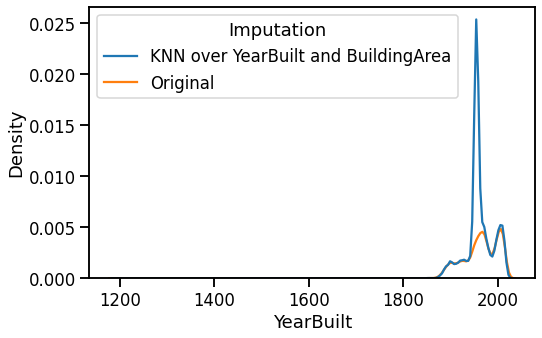

In [18]:
mice_year_built = melb_data_mice.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = melb_df.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pandas.concat([mice_year_built, melb_year_build]).reset_index()
fig = plt.figure(figsize=(8, 5))
g = seaborn.kdeplot(data=data, x='YearBuilt', hue='Imputation')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

### Solución
Previo a aplicar PCA se escalan los datos

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_dense_feature_matrix = scaler.fit_transform(melb_data_mice)
numpy.max(scaled_dense_feature_matrix), numpy.min(scaled_dense_feature_matrix)

(1.0000000000000009, -1.0)

Se instancia la clase PCA y se le pasa como parámetro los n componentes principales que se desean obtener

In [20]:
from sklearn.decomposition import PCA
n = min(20, scaled_dense_feature_matrix.shape[0])
n= n
pca = PCA(n_components=n)
pca.fit(scaled_dense_feature_matrix)
proyected_features = pca.transform(scaled_dense_feature_matrix)
proyected_features.shape

(12214, 20)

In [21]:
print("Principal components")
print(pca.components_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Principal components
[[-8.44160349e-05 -5.41550054e-05 -7.96607527e-05 ...  3.98680222e-01
  -2.23234481e-03 -2.87511385e-04]
 [-2.20713424e-07  1.30078320e-04 -2.76705854e-05 ... -1.17447236e-01
   7.72313057e-03 -3.49936840e-05]
 [-2.89789749e-05 -1.03743895e-05 -1.34338344e-04 ... -1.00047484e-01
   9.34785718e-03 -3.94340469e-04]
 ...
 [-2.01208237e-04 -2.73772691e-04 -3.03178886e-05 ...  8.10330183e-02
   1.49655928e-02  3.04766481e-04]
 [ 3.50802676e-04 -3.52973426e-05 -5.35374914e-05 ...  5.37172804e-03
   9.95480132e-04  8.33936239e-05]
 [-6.84671434e-05  8.21885016e-05  2.41387721e-05 ...  2.01805215e-04
   3.31488396e-03 -2.04388033e-04]]
Explained variance ratio
[0.12205309 0.05636337 0.04403812 0.04044075 0.03671834 0.02355849
 0.01675807 0.01571    0.01519415 0.0143707  0.01318277 0.01151465
 0.01067211 0.01039986 0.01003035 0.0091241  0.00894027 0.00859214
 0.00748203 0.00716774]


Se grafica la varianza de cada PC mediante un Scree Plot

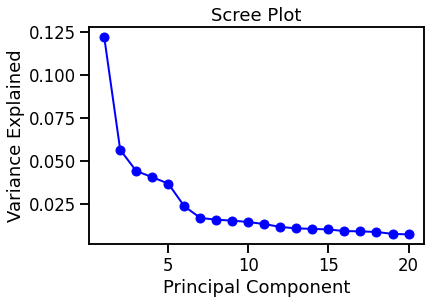

In [22]:
PC_values = numpy.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Con los componentes principales obtenidos se crea un DataFrame como paso previo para luego concatenarlos con el DataFrame importado en el ejercicio 1

In [23]:
pca_df = pandas.DataFrame(data = proyected_features, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6',
                                                              'PC 7','PC 8','PC 9','PC 10','PC 11','PC 12',
                                                            'PC 13','PC 14','PC 15','PC 16','PC 17','PC 18',
                                                            'PC 19','PC 20',])
print(pca_df)

           PC 1      PC 2      PC 3      PC 4      PC 5      PC 6      PC 7  \
0      1.954588 -2.029271  0.255002 -1.042214 -0.128425  0.032759 -0.194643   
1      1.948879 -2.057128  0.311732 -0.946162 -0.036869  0.066905 -0.276339   
2      2.005184 -1.977651 -0.081125  0.843412 -1.676753  0.108199 -0.899176   
3      2.009040 -1.876827  0.015602  0.649403 -1.684318  0.134785  0.241552   
4      1.961022 -2.179393  0.091330  0.513356 -1.534139 -0.275079  1.445049   
...         ...       ...       ...       ...       ...       ...       ...   
12209 -1.604641 -1.015423  0.892885 -0.636486  0.057944 -0.176175 -0.393869   
12210  1.438933 -0.851523 -0.918256 -1.139822  0.153214  0.985163 -0.488496   
12211  1.850916 -1.087941 -2.342715  1.429850 -0.585371  0.081519 -1.013347   
12212  1.766086 -1.155350 -1.997384 -0.487925  0.911427 -0.014143 -0.256324   
12213 -1.730564 -0.202271 -1.648746  1.669473 -0.596512 -0.347998 -1.021222   

           PC 8      PC 9     PC 10     PC 11     P

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

En base a lo que se puede observar en el Scree Plot del ejercicio anterior, podría afirmarse que los 6 primeros componentes principales son los responsables del mayor porcentaje de varianza en los datos. En base a ello, se optó por adicionarlos como nuevas columans al DataFrame importado en el ejercicio 1

### Solución
Se concatenan los 5 primeros PC con el dataframe

In [24]:
processed_melb_df = pandas.concat([melb_data_mice,pca_df.iloc[:,:6]], axis = 1)
processed_melb_df.head()

,Address=1 Adelle Ct,Address=1 Airlie St,Address=1 Albion Ct,Address=1 Alexander St,Address=1 Alma St,Address=1 Ann St,Address=1 Arthur St,Address=1 Ash Gr,Address=1 Ashdown Ct,Address=1 Aspen St,...,airbnb_weekly_price_mean,zipcode,YearBuilt,BuildingArea,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,605.152161,3067.0,1955.0,121.4,1.954588,-2.029271,0.255002,-1.042214,-0.128425,0.032759
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,605.152161,3067.0,1900.0,79.0,1.948879,-2.057128,0.311732,-0.946162,-0.036869,0.066905
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,605.152161,3067.0,1900.0,150.0,2.005184,-1.977651,-0.081125,0.843412,-1.676753,0.108199
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,605.152161,3067.0,1955.0,121.4,2.009040,-1.876827,0.015602,0.649403,-1.684318,0.134785
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,605.152161,3067.0,2014.0,142.0,1.961022,-2.179393,0.091330,0.513356,-1.534139,-0.275079


Se genera el export del nuevo Dataset

In [25]:
processed_melb_df.to_csv("melb_data_extended_with_PCA.csv", index=None)
files.download("melb_data_extended_with_PCA.csv")

#el archivo generado en esta linea no se puede subir al repositorio por que es muy pesado

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso.

*Se sube un archivo PDF [Ejercicio 5 - Documentación Técnica.md] para este punto*
